In [1]:
import pandas as pd
import numpy as np

import pywt
import cv2 as cv2
import os
import shutil

import seaborn as sn
from matplotlib import pyplot as plt
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn import svm

from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report

import json
import joblib

In [2]:
img_path = "FootballPlayerImageClassifier/model/dataset/"
cropped_path = "FootballPlayerImageClassifier/model/dataset/cropped/"
opnecv_harr_cascade = "FootballPlayerImageClassifier/model/opencv/"
img_dictionary_path = "FootballPlayerImageClassifier/model/"

In [3]:
img = cv2.imread(img_path+'lionel_messi/2.jpg')
img.shape

(1067, 912, 3)

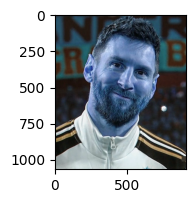

In [4]:
img_width = 6
img_height = 2

plt.figure(figsize=(img_width, img_height))
plt.imshow(img)

In [5]:
#convert image color space
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray.shape

(1067, 912)

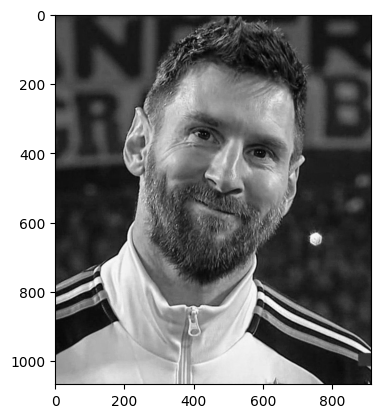

In [6]:
#plt.figure(figsize=(img_width, img_height))
plt.imshow(gray, cmap='gray')

In [7]:
# Detect faces using Haar Cascade classifier
face_cascade = cv2.CascadeClassifier(opnecv_harr_cascade+'haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier(opnecv_harr_cascade+'haarcascade_eye.xml')

# gray: The grayscale image on which to perform face detection
# scaleFactor: Controls image scaling at each step. Smaller values make detection more sensitive to small faces
# minNeighbors: Specifies the number of neighbors a region should have to be considered as a face
face = face_cascade.detectMultiScale(gray, 1.1, 3)
face

array([[238, 175, 526, 526]])

In [8]:
(x, y, w, h) = face[0]
x, y, w, h

(238, 175, 526, 526)

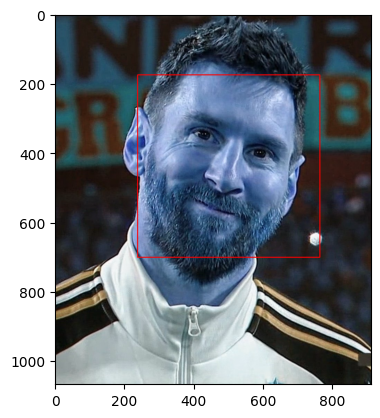

In [9]:
rectangle_img = cv2.rectangle(img, (x,y), (x+w, y+h), (255, 0, 0), 2)
plt.imshow(rectangle_img)

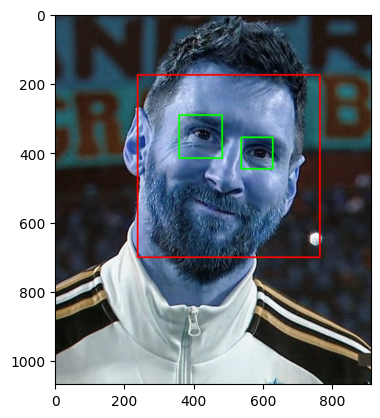

In [10]:
cv2.destroyAllWindows()
faces = face_cascade.detectMultiScale(gray, 1.1, 3)
for (x,y,w,h) in faces:
    img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0), 3)
    roi_gray = gray[y:y+h, x:x+w]
    roi_color = img[y:y+h, x:x+w]
    eyes = eye_cascade.detectMultiScale(roi_gray, 1.3 ,3)
    for (ex,ey,ew,eh) in eyes:
        cv2.rectangle(roi_color,(ex,ey),(ex+ew,ey+eh),(0,255,0), 3)

plt.figure()
plt.imshow(img, cmap="gray")
plt.show()

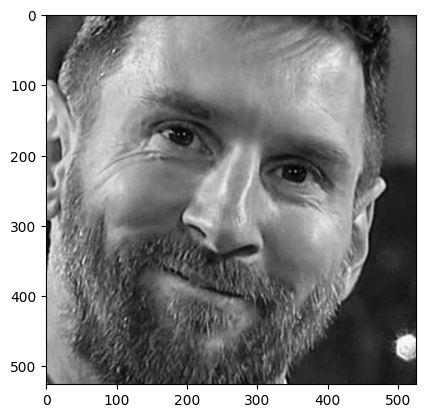

In [11]:
plt.imshow(roi_gray, cmap="gray")

In [12]:
def get_cropped_images(image_path):
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.1, 3)
    for (x, y, w, h) in faces:
        roi_gray = gray[y:y+h, x:x+w]
        roi_color = img[y:y+h, x:x+w]
        eyes = eye_cascade.detectMultiScale(roi_gray, 1.3, 3)
        if len(eyes) >= 2:
            return roi_color

## Cropped

In [13]:
# Get all sub fodlers
"""files = os.listdir(img_path)
files"""

'files = os.listdir(img_path)\nfiles'

In [14]:
# Create cropped folder if not exists and remove previosus version
"""if os.path.exists(cropped_path):
    shutil.rmtree(cropped_path)
os.makedirs(cropped_path)"""

'if os.path.exists(cropped_path):\n    shutil.rmtree(cropped_path)\nos.makedirs(cropped_path)'

In [15]:
"""img_dirs = [file for file in files if file != "cropped"]
cropped_image_dirs = []
sport_file_name_dict = {}

for img_dir in img_dirs:
    
    print(f"---{img_dir}---")
    
    sport_file_name_dict[img_dir] = []
    
    for entry in os.scandir(f'{img_path}{img_dir}'):
        path = (img_path + img_dir + ('/') + entry.name)
        print(path)
        
        roi_color = get_cropped_images(path)
        
        print(entry.name)
        
        if roi_color is not None:
            cropped_folder = cropped_path + img_dir
            print("Validation of the image is successful \n")
            
            if not os.path.exists(cropped_folder):
                os.makedirs(cropped_folder)
                print("Genearting cropped images in folders \n")
                
            cropped_file_name = (cropped_folder + ('/') + entry.name)
            print(cropped_file_name)
                
            cv2.imwrite(cropped_file_name, roi_color)
            sport_file_name_dict[img_dir].append(cropped_file_name)
            print(f"Saved the cropped image {entry.name} \n")
        else:
            print("Not valid \n")
            """

'img_dirs = [file for file in files if file != "cropped"]\ncropped_image_dirs = []\nsport_file_name_dict = {}\n\nfor img_dir in img_dirs:\n    \n    print(f"---{img_dir}---")\n    \n    sport_file_name_dict[img_dir] = []\n    \n    for entry in os.scandir(f\'{img_path}{img_dir}\'):\n        path = (img_path + img_dir + (\'/\') + entry.name)\n        print(path)\n        \n        roi_color = get_cropped_images(path)\n        \n        print(entry.name)\n        \n        if roi_color is not None:\n            cropped_folder = cropped_path + img_dir\n            print("Validation of the image is successful \n")\n            \n            if not os.path.exists(cropped_folder):\n                os.makedirs(cropped_folder)\n                print("Genearting cropped images in folders \n")\n                \n            cropped_file_name = (cropped_folder + (\'/\') + entry.name)\n            print(cropped_file_name)\n                \n            cv2.imwrite(cropped_file_name, roi_color)\n  

In [16]:
# Save the dictionary to Json file
"""file_path = (img_dictionary_path+'sport_file_name_dict.json')
with open(file_path, 'w') as file:
    json.dump(sport_file_name_dict, file)"""

"file_path = (img_dictionary_path+'sport_file_name_dict.json')\nwith open(file_path, 'w') as file:\n    json.dump(sport_file_name_dict, file)"

In [17]:
# Read the dictionay
file_path = (img_dictionary_path+'sport_file_name_dict.json')
with open(file_path, 'r') as file:
    retrieved_file = json.load(file)

In [18]:
retrieved_file

{'kylian_mbappe': ['FootballPlayerImageClassifier/model/dataset/cropped/kylian_mbappe/1.jpg',
  'FootballPlayerImageClassifier/model/dataset/cropped/kylian_mbappe/13.jpg',
  'FootballPlayerImageClassifier/model/dataset/cropped/kylian_mbappe/14.jpg',
  'FootballPlayerImageClassifier/model/dataset/cropped/kylian_mbappe/18.jpg',
  'FootballPlayerImageClassifier/model/dataset/cropped/kylian_mbappe/19.jpg',
  'FootballPlayerImageClassifier/model/dataset/cropped/kylian_mbappe/2.jpg',
  'FootballPlayerImageClassifier/model/dataset/cropped/kylian_mbappe/29.jpg',
  'FootballPlayerImageClassifier/model/dataset/cropped/kylian_mbappe/3.jpg',
  'FootballPlayerImageClassifier/model/dataset/cropped/kylian_mbappe/37.jpg',
  'FootballPlayerImageClassifier/model/dataset/cropped/kylian_mbappe/38.jpg',
  'FootballPlayerImageClassifier/model/dataset/cropped/kylian_mbappe/4.jpg',
  'FootballPlayerImageClassifier/model/dataset/cropped/kylian_mbappe/47.jpg',
  'FootballPlayerImageClassifier/model/dataset/crop

## Wavelet Transform

In [19]:
def w2d(image, model='haar', level=1):
    imArray = image
    
    # Convert to grayscale
    imArray = cv2.cvtColor(imArray, cv2.COLOR_RGB2GRAY)
    # Convert to float
    imArray = np.float32(imArray)
    # Scales the pixel values of the image to the range [0, 1] by dividing each pixel value by 255
    imArray /= 255;
    # Compute cofficinets
    coeffs = pywt.wavedec2(imArray, model, level=level)
    
    # Process Coefficinets
    coeffs_H = list(coeffs)
    # Remove low-frequency information
    coeffs_H[0] *= 0;
    
    # Reconstruction
    imArray_H = pywt.waverec2(coeffs_H, model);
    imArray_H *= 255;
    imArray_H = np.uint8(imArray_H)
    return imArray_H
    

In [20]:
img_cropped = cv2.imread(cropped_path+'lionel_messi/2.jpg')

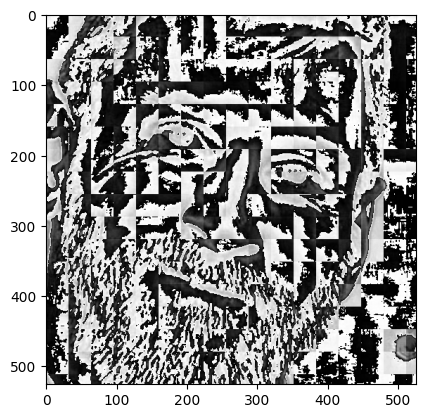

In [21]:
im_har = w2d(img_cropped, 'db1', 5)
plt.imshow(im_har, cmap='gray')

## Combine cropped images and wavelet transformed images

In [22]:
class_dictionary = {}
count = 0
for name in retrieved_file.keys():
    class_dictionary[name] = count
    count += 1
class_dictionary

{'kylian_mbappe': 0,
 'lionel_messi': 1,
 'neymar_jr': 2,
 'robert_lewandowski': 3}

In [23]:
features, y = [], []
for name, cropped_files in retrieved_file.items():
    for cropped_file in cropped_files:
        img = cv2.imread(cropped_file)
        # Check if the image was successfully read
        if img is None:
            # Skip to the next iteration if the image is not valid
            continue
        # Resize the image to a fixed size of 32x32 pixels
        scalled_row_image = cv2.resize(img, (32, 32))
        img_har = w2d(img, 'db1', 5)
        # Resize the wavelet transformed image to 32x32 pixels
        scalled_img_har = cv2.resize(im_har, (32, 32))
        # Vertically stack the resized original image and the wavelet transformed image
        comnined_img = np.vstack((scalled_row_image.reshape(32*32*3,1), scalled_img_har.reshape(32*32,1)))
        features.append(comnined_img)
        y.append(class_dictionary[name])

In [24]:
len(features[0])

4096

In [25]:
class_dictionary['kylian_mbappe']

0

In [26]:
features[0]

array([[ 93],
       [103],
       [121],
       ...,
       [250],
       [  0],
       [  1]], dtype=uint8)

In [27]:
X = np.array(features).reshape(len(features), 4096).astype(float)

In [28]:
X.shape

(90, 4096)

In [29]:
X[0]

array([ 93., 103., 121., ..., 250.,   0.,   1.])

## Modle Training

In [30]:
model_params = {
        'SVC':{
            'model':svm.SVC(gamma='auto', probability=True ),
            'params':{
                'model__C': [0.1, 1, 10, 100, 1000],
                'model__kernel': ['rbf', 'linear']
            }
        },

       'XGBoost':{
        'model':XGBClassifier(reg_alpha=0.1, reg_lambda=1 ),
        'params': {
            'model__n_estimators': [100, 200],
            'model__learning_rate': [0.01, 0.1],
            'model__max_depth': [3, 7],
        }
    }
}

In [31]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

In [32]:
# Initialize Stratified-KFold cross-validation
skf_cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=0) 

In [33]:
# Initialize GridSearchCV
best_model_name = ""
best_model = None
best_params = None
best_score = 0

scores = []
best_estimators = {}


for model_name, model in model_params.items():
    
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('model', model['model'])
    ])
    
    grid = GridSearchCV(estimator=pipeline, param_grid=model['params'], cv=skf_cv, return_train_score=False, verbose=False)
    grid.fit(X_train, y_train)
    
    models = model_name
    current_best_score = grid.best_score_

    print(f"Best parameters for {models} : {grid.best_params_}")
    print(F"Best Accuracy for {models} is {current_best_score} \n")

    scores.append({
        'models':models,
        'best_params': grid.best_params_,
        'best_score': current_best_score
    })
    
    best_estimators[model_name] = grid.best_estimator_

    # Best model with best parameters
    if current_best_score > best_score:
        best_score = current_best_score
        best_model_name = model_name
        best_model = grid.best_estimator_
        best_params = grid.best_params_

print(f"The best model is {best_model_name} with parameters {best_params}")
pd.DataFrame(scores, columns=list(scores[0].keys()))

Best parameters for SVC : {'model__C': 0.1, 'model__kernel': 'linear'}
Best Accuracy for SVC is 0.7083333333333334 

Best parameters for XGBoost : {'model__learning_rate': 0.1, 'model__max_depth': 3, 'model__n_estimators': 100}
Best Accuracy for XGBoost is 0.5555555555555556 

The best model is SVC with parameters {'model__C': 0.1, 'model__kernel': 'linear'}


,models,best_params,best_score
0,SVC,"{'model__C': 0.1, 'model__kernel': 'linear'}",0.708333
1,XGBoost,"{'model__learning_rate': 0.1, 'model__max_dept...",0.555556


In [34]:
best_estimators

{'SVC': Pipeline(steps=[('scaler', StandardScaler()),
                 ('model',
                  SVC(C=0.1, gamma='auto', kernel='linear', probability=True))]),
 'XGBoost': Pipeline(steps=[('scaler', StandardScaler()),
                 ('model',
                  XGBClassifier(base_score=None, booster=None, callbacks=None,
                                colsample_bylevel=None, colsample_bynode=None,
                                colsample_bytree=None,
                                early_stopping_rounds=None,
                                enable_categorical=False, eval_metric=None,
                                feature_types=None, gamma=None, gpu_id=None,
                                grow_policy=None, importance_type=None,
                                interaction_constraints=None, learning_rate=0.1,
                                max_bin=None, max_cat_threshold=None,
                                max_cat_to_onehot=None, max_delta_step=None,
                          

In [35]:
best_model

Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 SVC(C=0.1, gamma='auto', kernel='linear', probability=True))])

In [36]:
best_model_predict = best_model.predict(X_val)

In [37]:
cm = confusion_matrix(y_val, best_model_predict)
cm

array([[5, 0, 0, 0],
       [0, 6, 0, 0],
       [2, 0, 1, 0],
       [0, 0, 0, 4]], dtype=int64)

Text(45.722222222222214, 0.5, 'Actual')

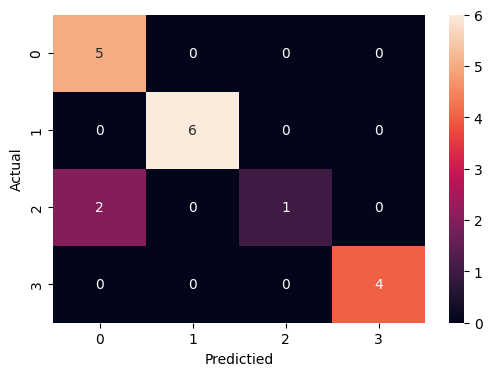

In [38]:
plt.figure(figsize=(6,4))
sn.heatmap(cm, annot=True)
plt.xlabel('Predictied')
plt.ylabel('Actual')

In [39]:
class_dictionary

{'kylian_mbappe': 0,
 'lionel_messi': 1,
 'neymar_jr': 2,
 'robert_lewandowski': 3}

## Validation

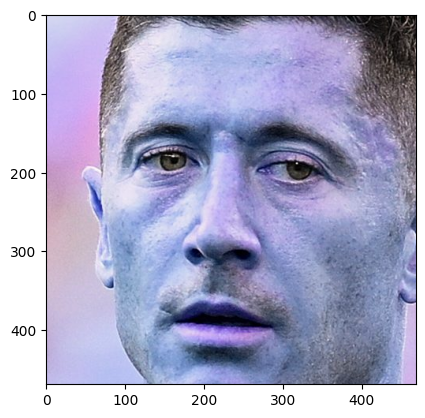

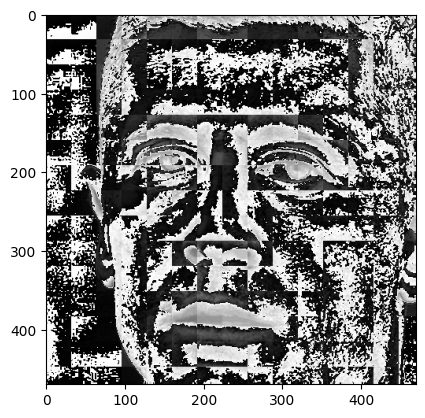

In [40]:
features_validation = []

img_cropped = get_cropped_images(img_dictionary_path+'test_images/2.jpg')
im_har = w2d(img_cropped, 'db1', 5)

plt.imshow(img_cropped, cmap='gray')
plt.show()

plt.imshow(im_har, cmap='gray')
plt.show()

scalled_row_image = cv2.resize(img_cropped, (32, 32))
scalled_img_har = cv2.resize(im_har, (32, 32))

comnined_img = np.vstack((scalled_row_image.reshape(32*32*3,1), scalled_img_har.reshape(32*32,1)))

features_validation.append(comnined_img)
features_validation

X_featue_validation = np.array(features_validation).reshape(len(features_validation), 4096).astype(float)

In [41]:
X_featue_validation

array([[213., 214., 240., ...,  38., 130., 215.]])

In [42]:
best_model.predict(X_featue_validation)

array([3])

## Save the model

In [43]:
best_clf = best_model

In [44]:
# Save the model to pickle file
joblib.dump(best_clf, 'best_model.pkl')

['best_model.pkl']

## Save the dictionary

In [45]:
class_dictionary

{'kylian_mbappe': 0,
 'lionel_messi': 1,
 'neymar_jr': 2,
 'robert_lewandowski': 3}

In [46]:
with open("class_dictionary.json", "w") as file:
    file.write(json.dumps(class_dictionary))